In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 43.4MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
from fastai import *

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd "/content/drive/My Drive/automatic-asset-classification"

/content/drive/My Drive/automatic-asset-classification


In [0]:
from fastai.vision import *

In [6]:
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
np.random.seed(3333)
torch.manual_seed(3333)

size = 224
batchsize = 32

tfms = get_transforms(do_flip = True)
data = ImageDataBunch.from_folder(image_path, valid_pct = 0.2, size=size,ds_tfms=tfms, bs = batchsize
                                 ).normalize(imagenet_stats)

print("imported")

imported


In [0]:
class classifier(nn.Module):
    '''
    a convolutional block used in the model:
    conv(in, out) -> batchnorm(out) -> relu
    '''
    def __init__(self):
      super(classifier,self).__init__()
      self.classify = nn.Sequential(nn.Flatten(),
                                       nn.BatchNorm1d(1024),
                                       nn.Dropout(p=0.25),
                                       nn.Linear(1024, 512),
                                       nn.ReLU(inplace=True),
                                       nn.BatchNorm1d(512),
                                       nn.Dropout(p=0.5),
                                       nn.Linear(512,6))
    def forward(self, x):
      return self.classify(x)


In [0]:
from fastai.torch_core import *
from fastai.core import ifnone
from fastai.layers import *

class reshape(nn.Module):
    '''a torch layer to reshape the input into size = shape = type list'''
    def __init__(self, shape):
        super(reshape, self).__init__()
        self.shape = shape
    def forward(self, x): return x.reshape(self.shape)

class convblock(nn.Module):
    '''
    a convolutional block used in the model:
    conv(in, out) -> batchnorm(out) -> relu
    '''
    def __init__(self, in_:int, out:int):
      super().__init__()
      self.conv1 = nn.Conv2d(in_, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      self.bn = nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
      x = self.conv1(x)
      x = self.bn(x)
      x = self.relu(x)
      return x

class downsamp(nn.Module):
    ''' a downsampling block. using adaptive max pooling so select the size to be outputted and the scale you would like output ie out (3,10,10) is a downsamp(3, 10).
    '''
    def __init__(self, size:int, scale:int=2):
      super().__init__()
      self.pool = nn.AdaptiveMaxPool2d(scale)
      self.bn = nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      self.relu = nn.ReLU(inplace = True)

    def forward(self,x):
      x = self.pool(x)
      x = self.bn(x)
      x = self.relu(x)
      return x

class Upsample(nn.Module):
    '''
    upsample by scale = scale. Ins and outs are input. Upsampling method is nearest neighbour.
    '''
    def __init__(self, in_:int, out:int, scale:int=2):
      super().__init__()
      self.upsample = nn.Upsample(scale_factor=scale, mode='nearest')
      self.bn = nn.BatchNorm2d(in_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      self.conv1 = nn.Sequential(
              nn.Conv2d(in_, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
              nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
              nn.ReLU(inplace=True)
              )

    def forward(self, x):
      x = self.upsample(x)
      x = self.bn(x)
      x = self.conv1(x)
      return x

In [0]:
class encoder(nn.Module):
    def __init__(self, model_weights=True):
        super(encoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = model_weights)
        resnet = nn.Sequential(*(list(resnet.children())[0:8]))
        if model_weights:
            for param in resnet.parameters():
                param.requires_grad = False
        else:
            for param in resnet.parameters():
                param.requires_grad = True


        self.encoder = nn.Sequential(resnet, AdaptiveConcatPool2d(), nn.Flatten())

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()

        self.bottleneck = nn.Sequential(nn.Linear(1024, 24 * 8 * 8),
                                        reshape([-1,24,8,8])
                                        )

        self.up1 = Upsample(24,12,scale=7)
        self.up2 = Upsample(12,6,scale=2)
        self.up3 = Upsample(6,3)

    def forward(self,x):
        x = self.bottleneck(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        return x

class autoencoder(nn.Module):
    def __init__(self, model_weights=True):
        super(autoencoder, self).__init__()

        self.encoder = encoder(model_weights)
        self.decoder = decoder()

    def encode(self, x): return self.encoder(x)
    def decode(self, x): return torch.clamp(self.decoder(x), min = 0, max = 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.clamp(x, min = 0, max = 1)


In [0]:
%cp "/content/drive/My Drive/automatic-asset-classification/models/resnet_autoencoder_model.pt" "resnet_autoencoder_model.pt"

In [0]:
class full_model(nn.Module):
      def __init__(self):
        super(full_model, self).__init__()

        self.body = torch.load("resnet_autoencoder_model.pt").encoder
        for param in self.body.parameters():
          param.requires_grad = False

        self.head = classifier()

      def forward(self,x):
        x = self.body(x)
        x = self.head(x)
        return x

In [0]:
FM = full_model()
learn = Learner(data, FM, metrics=error_rate)

In [33]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.834829,1.753266,0.627273,00:12
1,1.759761,1.647249,0.572727,00:12
2,1.676465,1.670143,0.536364,00:12
3,1.589662,1.443165,0.518182,00:12
4,1.533291,1.432421,0.527273,00:12


In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-05


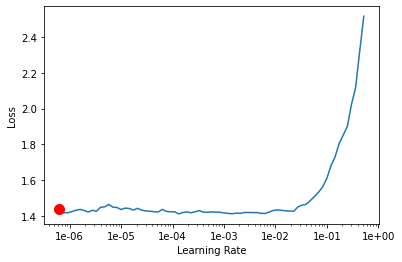

In [35]:
learn.recorder.plot(suggestion=True)

In [36]:
learn.fit_one_cycle(15, tot_epochs=20, start_epoch = 0, max_lr = 5e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.395311,1.423104,0.518182,00:12
1,1.373433,1.403109,0.500000,00:12
2,1.372208,1.506997,0.581818,00:12
3,1.382503,1.585038,0.618182,00:12
4,1.423791,1.477125,0.563636,00:12
5,1.492291,1.550469,0.554545,00:12
6,1.531679,1.421890,0.545455,00:12
7,1.546648,1.411184,0.536364,00:12
8,1.551354,1.382854,0.527273,00:12
9,1.549381,1.536924,0.618182,00:12


In [37]:
learn.split(lambda m: (m.body.encoder[0][1], m.body.encoder[0][2], m.body.encoder[0][3], m.body.encoder[0][4], m.body.encoder[0][5], 
                       m.body.encoder[0][6], m.body.encoder[0][7], m.body.encoder[1], m.head))
print("model split")

model split


In [39]:
learn.unfreeze()
learn.fit_one_cycle(20, start_epoch=15, tot_epochs=20, max_lr = slice(1e-06,1e-02))

epoch,train_loss,valid_loss,error_rate,time
15,1.495560,1.309198,0.427273,00:12
16,1.384009,1.195472,0.463636,00:13
17,1.279806,1.118228,0.418182,00:13
18,1.175171,1.065832,0.409091,00:12
19,1.127446,1.053136,0.409091,00:13


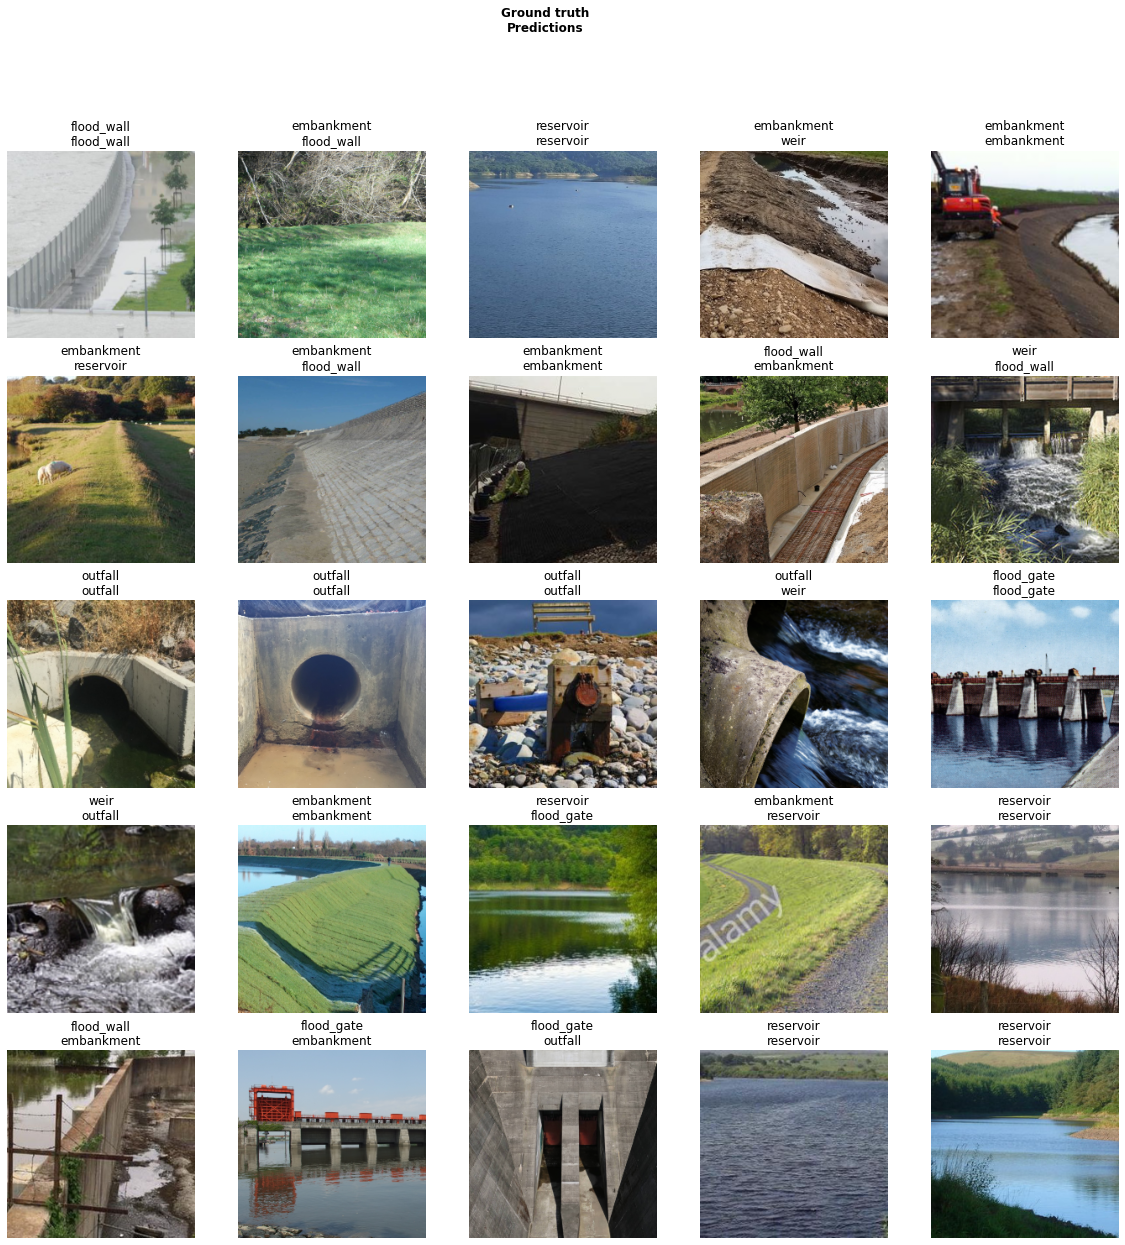

In [40]:
learn.show_results()